In [ ]:
!pip install -qU langgraph langchain tavily-python langchain_openai

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'
os.environ['TAVILY_API_KEY'] = 'YOUR_TAVILY_API_KEY'

# Reflection

In the context of LLM agent building, **Reflection** refers to the process of prompting an LLM to observe its past steps (along with potential observations from tools or the environment) to assess the quality of the chosen actions. This is then used downstream for tasks like re-planning, search, or evaluation.

# Generate

In [10]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name='messages'),
    ]
)

llm = ChatOpenAI(
    model='gpt-3.5-turbo',
    max_tokens=4096,
)

generate = prompt | llm

We created a "5 paragraph essay" generator.

In [11]:
essay = ""
request = HumanMessage(
    content='Write an essay on why the little prince is relevant in modern childhood'
)

for chunk in generate.stream({'messages': [request]}):
    print(chunk.content, end='')
    essay += chunk.content

"The Little Prince" by Antoine de Saint-Exupéry continues to captivate readers of all ages with its timeless wisdom and profound insights. In today's fast-paced and technology-driven world, the themes and messages in this classic tale remain as relevant as ever, especially in shaping the modern childhood experience.

One of the key reasons why "The Little Prince" is still pertinent in modern childhood is its emphasis on the importance of imagination and creativity. In an era dominated by screens and electronic devices, children are often encouraged to consume rather than create. The Little Prince encourages young readers to see the world through a different lens, one that values imagination and curiosity. The Little Prince's ability to see beyond the surface and appreciate the beauty of the invisible is a powerful lesson for children growing up in a world filled with distractions.

Furthermore, the book addresses complex themes such as friendship, love, and loss, which are universal ex

## Reflect

In [12]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name='messages'),
    ]
)

reflect = reflection_prompt | llm

In [13]:
reflection = ""

for chunk in reflect.stream({'messages': [request, HumanMessage(content=essay)]}):
    print(chunk.content, end='')
    reflection += chunk.content

Your essay provides a good overview of why "The Little Prince" is relevant in modern childhood, but it could benefit from some additional depth and analysis to strengthen your argument. Here are some suggestions for improvement:

1. **Add specific examples**: Incorporate specific examples from the book to support your points. For instance, you could discuss the Little Prince's interactions with characters like the fox and the rose to illustrate the themes of friendship and love. This will make your argument more persuasive and engaging.

2. **Expand on the impact of technology**: While you briefly mention the prevalence of screens and electronic devices in today's world, you could delve deeper into how this impacts children's development and how the messages of "The Little Prince" offer a valuable counterbalance to these influences.

3. **Consider discussing the role of parents and educators**: Explore how parents and educators can use "The Little Prince" to help children navigate the 

## Repeat

We can repeat reflection in a loop for a fixed number of steps or use a LLM to decide when the finished product is good enough.

In [14]:
for chunk in generate.stream(
    {
        'messages': [
            request,
            AIMessage(content=essay),
            HumanMessage(content=reflection),
        ]
    }
):
    print(chunk.content, end='')

"The Little Prince" by Antoine de Saint-Exupéry holds a special place in the hearts of readers young and old, resonating with its timeless themes and profound insights. In today's rapidly changing world, the messages conveyed in this classic tale continue to be relevant in shaping the experiences of modern childhood.

One of the reasons why "The Little Prince" remains pertinent in modern childhood is its celebration of imagination and creativity. In a society dominated by technology and screens, children are often encouraged to passively consume rather than actively create. Through the Little Prince's encounters with various characters and his exploration of different worlds, the book inspires young readers to embrace their imagination and curiosity. For example, the Little Prince's interactions with the fox highlight the importance of forming meaningful connections and looking beyond the surface to see the essence of things.

Moreover, "The Little Prince" delves into complex themes su

# Define Graph

In [19]:
from typing import Annotated, List, Sequence
from typing_extensions import TypedDict

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    messages: Annotated[List, add_messages]


async def generation_node(state: State) -> State:
    return {
        'messages': [await generate.ainvoke(state['messages'])]
    }

async def reflection_node(state: State) -> State:
    # Other messages we need to adjust
    cls_map = {
        'ai': HumanMessage,
        'human': AIMessage,
    }

    # First message is the original user request. We hold it the same for all nodes
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    res = await reflect.ainvoke(translated)

    # We treat the output of this as human feedback for the generator
    return {
        'messages': [HumanMessage(content=res.content)]
    }

In [20]:
builder = StateGraph(State)
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)

builder.add_edge(START, 'generate')


def should_continue(state: State):
    if len(state['messages']) > 6:
        # End after 3 iterations
        return END
    return 'reflect'

builder.add_conditional_edges('generate', should_continue)
builder.add_edge('reflect', 'generate')

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

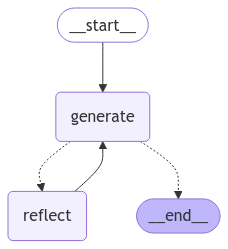

In [21]:
from IPython.display import Image, display

display(Image(
    graph.get_graph(xray=True).draw_mermaid_png(),
))

In [23]:
config = {'configurable': {'thread_id': '001'}}

async for event in graph.astream(
    {
        'messages': [
            HumanMessage(
                content='Generate an essay on the topicality of The Little Prince and its message in modern life.'
            )
        ],
    },
    config=config,
):
    print(event)
    print('--------')

{'generate': {'messages': [AIMessage(content='"The Little Prince" by Antoine de Saint-Exupéry is a timeless classic that continues to resonate with readers of all ages due to its profound and thought-provoking messages. Despite being written in 1943, the themes and lessons found within the pages of this novella remain strikingly relevant in modern life. In today\'s fast-paced and materialistic world, the story of the little prince serves as a poignant reminder of the importance of innocence, imagination, and human connections.\n\nOne of the central messages of "The Little Prince" that holds particular significance in modern life is the importance of looking beyond the surface to truly see and understand the world around us. In a society that often values appearances and superficial success, the little prince\'s interactions with the fox emphasize the idea that what is essential is invisible to the eye. This message encourages readers to cultivate a deeper understanding of the people an

In [24]:
state = graph.get_state(config)

ChatPromptTemplate.from_messages(state.values['messages']).pretty_print()

================================ Human Message =================================

Generate an essay on the topicality of The Little Prince and its message in modern life.

================================== Ai Message ==================================

"The Little Prince" by Antoine de Saint-Exupéry is a timeless classic that continues to resonate with readers of all ages due to its profound and thought-provoking messages. Despite being written in 1943, the themes and lessons found within the pages of this novella remain strikingly relevant in modern life. In today's fast-paced and materialistic world, the story of the little prince serves as a poignant reminder of the importance of innocence, imagination, and human connections.

One of the central messages of "The Little Prince" that holds particular significance in modern life is the importance of looking beyond the surface to truly see and understand the world around us. In a society that often values appearances and superficial su